# Question 1: Word2Vec

Importing libraries and reading data

In [182]:
import pandas as pd
from bs4 import BeautifulSoup             
import re
import nltk
from nltk.corpus import stopwords # Import the stop word list
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import roc_auc_score,accuracy_score, roc_curve,auc
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt


train = pd.read_csv("labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
test  = pd.read_csv("testData.tsv", header=0, delimiter="\t", quoting=3)
unlabeled_train = pd.read_csv( "unlabeledTrainData.tsv", header=0, delimiter="\t", quoting=3 )


[Kaggle tutorial blog](https://www.kaggle.com/c/word2vec-nlp-tutorial#part-2-word-vectors) instructions followed to create functions and models below.


Function to convert raw review text to word lists 

In [183]:

def review_to_wordlist( review, remove_stopwords=False ):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(review, "html5lib").get_text()
    #  
    # 2. Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    #
    # 3. Convert words to lower case and split them
    words = review_text.lower().split()
    #
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    #
    # 5. Return a list of words
    return(words)

The Word2Vec model expects sentences as its input. Hence, we will create a function to split sentences with the punkt tokenizer.

In [184]:
# Download the punkt tokenizer for sentence splitting
import nltk.data
nltk.download('punkt')   

# Load the punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
# Define a function to split a review into parsed sentences
def review_to_sentences( review, tokenizer, remove_stopwords=False ):
    # Function to split a review into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words
    #
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.strip())
    #
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append( review_to_wordlist( raw_sentence, \
              remove_stopwords ))
    #
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences

[nltk_data] Downloading package punkt to /Users/anuragroy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Parsing sentences from the datasets.

In [185]:
sentences = []  # Initialize an empty list of sentences

print ("Parsing sentences from training set")
for review in train["review"]:
    sentences += review_to_sentences(review, tokenizer)

print ("Parsing sentences from unlabeled set")
for review in unlabeled_train["review"]:
    sentences += review_to_sentences(review, tokenizer)

print ("\n Parsing complete")

Parsing sentences from training set


/Users/anuragroy/miniconda3/lib/python3.5/site-packages/bs4/__init__.py:219: UserWarning: "b'.'" looks like a filename, not markup. You shouldprobably open this file and pass the filehandle intoBeautiful Soup.
  'Beautiful Soup.' % markup)
/Users/anuragroy/miniconda3/lib/python3.5/site-packages/bs4/__init__.py:282: UserWarning: "http://www.happierabroad.com"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Parsing sentences from unlabeled set


/Users/anuragroy/miniconda3/lib/python3.5/site-packages/bs4/__init__.py:282: UserWarning: "http://www.archive.org/details/LovefromaStranger"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/anuragroy/miniconda3/lib/python3.5/site-packages/bs4/__init__.py:282: UserWarning: "http://www.loosechangeguide.com/LooseChangeGuide.html"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/anuragroy/miniconda3/lib/python3.5/site-packages/bs4/__init__.py:282: UserWarning: "http://www.msnbc.msn.com/id/4972055/site/newsweek/"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an 


 Parsing complete


In [186]:
# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)


## Part a)

We will now use word2vec to create vector representations for each model

In [187]:

# Set values for various parameters
num_features = 100    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 5          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print ("Training model...")
model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

2017-04-21 21:06:25,974 : INFO : collecting all words and their counts
2017-04-21 21:06:25,975 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-04-21 21:06:26,043 : INFO : PROGRESS: at sentence #10000, processed 225803 words, keeping 17776 word types
2017-04-21 21:06:26,108 : INFO : PROGRESS: at sentence #20000, processed 451892 words, keeping 24948 word types


Training model...


2017-04-21 21:06:26,168 : INFO : PROGRESS: at sentence #30000, processed 671315 words, keeping 30034 word types
2017-04-21 21:06:26,233 : INFO : PROGRESS: at sentence #40000, processed 897815 words, keeping 34348 word types
2017-04-21 21:06:26,288 : INFO : PROGRESS: at sentence #50000, processed 1116963 words, keeping 37761 word types
2017-04-21 21:06:26,351 : INFO : PROGRESS: at sentence #60000, processed 1338404 words, keeping 40723 word types
2017-04-21 21:06:26,407 : INFO : PROGRESS: at sentence #70000, processed 1561580 words, keeping 43333 word types
2017-04-21 21:06:26,469 : INFO : PROGRESS: at sentence #80000, processed 1780887 words, keeping 45714 word types
2017-04-21 21:06:26,528 : INFO : PROGRESS: at sentence #90000, processed 2004996 words, keeping 48135 word types
2017-04-21 21:06:26,589 : INFO : PROGRESS: at sentence #100000, processed 2226967 words, keeping 50207 word types
2017-04-21 21:06:26,648 : INFO : PROGRESS: at sentence #110000, processed 2446581 words, keeping 

## Part b)

In [188]:
# Load Google's pre-trained Word2Vec model.
import gensim
google_model = gensim.models.KeyedVectors.load_word2vec_format('/Users/anuragroy/Downloads/GoogleNews-vectors-negative300.bin', \
                                                               binary=True) 

2017-04-21 21:07:21,426 : INFO : loading projection weights from /Users/anuragroy/Downloads/GoogleNews-vectors-negative300.bin
2017-04-21 21:08:16,758 : INFO : loaded (3000000, 300) matrix from /Users/anuragroy/Downloads/GoogleNews-vectors-negative300.bin


In [189]:
google_dict = dict(zip(google_model.index2word,range(len(google_model.index2word))))

## Part c)

Creating set Z1, and clustering into 10 segments:

In [190]:
from sklearn.cluster import KMeans
import time

start = time.time() # Start time
 
Z1 = model.wv.syn0
num_clusters = 10  

# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans( n_clusters = num_clusters )
idx = kmeans_clustering.fit_predict(Z1)

# Get the end time and print how long the process took
end = time.time()
elapsed = end - start
print ("Time taken for K Means clustering (Z1): ", elapsed, "seconds.")

Time taken for K Means clustering (Z1):  3.520582914352417 seconds.


In [191]:
word_centroid_map = dict(zip( model.wv.index2word, idx ))

Sample of 20 words from each cluster:

In [192]:
for clust in range(10):
    print ("\nCluster:", clust+1, "\n")
    word_list = [key for key, val in word_centroid_map.items() if val == clust][:20]
    print (word_list)


Cluster: 1 

['armageddon', 'norris', 'puppet', 'franchise', 'candyman', 'bullshit', 'yikes', 'marple', 'indy', 'penultimate', 'foremost', 'ingmar', 'serial', 'chan', 'dutch', 'maestro', 'pales', 'midnight', 'swashbuckler', 'swashbuckling']

Cluster: 2 

['suburb', 'aboard', 'mutants', 'union', 'warp', 'rendezvous', 'detectives', 'voodoo', 'continental', 'houses', 'fools', 'oil', 'championship', 'lab', 'areas', 'crust', 'petrified', 'thieves', 'pow', 'jewels']

Cluster: 3 

['corn', 'um', 'bait', 'chunks', 'cursing', 'throats', 'spiders', 'calendar', 'drill', 'hefty', 'eggs', 'grinning', 'hangs', 'boob', 'thrown', 'screeching', 'vent', 'flashes', 'grocery', 'yelled']

Cluster: 4 

['aspects', 'integrity', 'avoiding', 'persistent', 'destruction', 'symbol', 'baggage', 'relations', 'budgetary', 'principle', 'continuing', 'layers', 'rampant', 'observations', 'expansion', 'abduction', 'anger', 'profession', 'human', 'advantage']

Cluster: 5 

['wow', 'funniest', 'entire', 'independent', 'b

In [193]:
def create_bag_of_centroids( wordlist, word_centroid_map ):
    #
    # The number of clusters is equal to the highest cluster index
    # in the word / centroid map
    num_centroids = max( word_centroid_map.values() ) + 1
    #
    # Pre-allocate the bag of centroids vector (for speed)
    bag_of_centroids = np.zeros( num_centroids, dtype="float32" )
    #
    # Loop over the words in the review. If the word is in the vocabulary,
    # find which cluster it belongs to, and increment that cluster count 
    # by one
    for word in wordlist:
        if word in word_centroid_map:
            index = word_centroid_map[word]
            bag_of_centroids[index] += 1
    #
    # Return the "bag of centroids"
    return bag_of_centroids

In [194]:
# ****************************************************************
# Calculate average feature vectors for training and testing sets,
# using the functions we defined above. Notice that we now use stop word
# removal.

clean_train_reviews = []
for review in train["review"]:
    clean_train_reviews.append( review_to_wordlist( review, \
        remove_stopwords=True ))
    
clean_test_reviews = []
for review in test["review"]:
    clean_test_reviews.append( review_to_wordlist( review, \
        remove_stopwords=True ))    



#### Creating design matrices X1 and X1_test

In [195]:

# Pre-allocate an array for the training set bags of centroids (for speed)
X1  = np.zeros( (train["review"].size, num_clusters), \
    dtype="float32" )

# Transform the training set reviews into bags of centroids
counter = 0
for review in clean_train_reviews:
    X1[counter] = create_bag_of_centroids( review, \
        word_centroid_map )
    counter += 1

# Repeat for test reviews 
X1_test = np.zeros(( test["review"].size, num_clusters), \
    dtype="float32" )

counter = 0
for review in clean_test_reviews:
    X1_test[counter] = create_bag_of_centroids( review, \
        word_centroid_map )
    counter += 1

#### To create set Z2, we will first subset Google's pretrained model to include only the terms in the word_centroid_map in the interest of speed:

In [196]:
from collections import defaultdict
google_dict2 = defaultdict()
for key in word_centroid_map.keys():
    try:
        google_dict2[key] = google_dict[key]
    except KeyError:
        continue

In [197]:
start = time.time() # Start time
 
Z2 = google_model.syn0[list(google_dict2.values())]
num_clusters = 10

# Initalize a k-means object and use it to extract centroids
kmeans_clustering2 = KMeans( n_clusters = num_clusters )
idx2 = kmeans_clustering2.fit_predict( Z2 )

# Get the end time and print how long the process took
end = time.time()
elapsed = end - start
print ("Time taken for K Means clustering: ", elapsed, "seconds.")

Time taken for K Means clustering:  9.9491708278656 seconds.


In [198]:
word_centroid_map2 = dict(zip(list(google_dict2.keys()), idx2 ))

Sample of 20 words from each cluster:

In [199]:
for clust in range(10):
    print ("\nCluster:", clust+1, "\n")
    word_list = [key for key, val in word_centroid_map2.items() if val == clust][:20]
    print (word_list)


Cluster: 1 

['meticulously', 'suspenseful', 'layered', 'femme', 'maestro', 'swashbuckler', 'comic', 'swashbuckling', 'lovemaking', 'artistically', 'documentaries', 'story', 'edited', 'jazzy', 'themes', 'scriptwriting', 'dialog', 'animator', 'extravaganza', 'scriptwriter']

Cluster: 2 

['integrity', 'destruction', 'baggage', 'relations', 'criticism', 'realist', 'principle', 'observations', 'handedly', 'anger', 'profession', 'voice', 'human', 'feel', 'fullest', 'downfall', 'allies', 'credentials', 'difficulties', 'boredom']

Cluster: 3 

['removes', 'hangs', 'pales', 'invites', 'uses', 'resides', 'feeds', 'rises', 'elevates', 'recovers', 'strives', 'tends', 'draws', 'disturbs', 'dominates', 'steals', 'prefers', 'concludes', 'crosses', 'refuses']

Cluster: 4 

['concentrating', 'stalwart', 'ridden', 'aboard', 'avoiding', 'fabricated', 'bothered', 'didn', 'remember', 'endured', 'perfected', 'penultimate', 'spaced', 'serving', 'acted', 'midnight', 'kept', 'thrown', 'nominated', 'hunted']

#### Creating design matrices X2 and X2_test

In [200]:
# Pre-allocate an array for the training set bags of centroids (for speed)
X2 = np.zeros( (train["review"].size, num_clusters), \
    dtype="float32" )

# Transform the training set reviews into bags of centroids
counter = 0
for review in clean_train_reviews:
    X2[counter] = create_bag_of_centroids( review, \
        word_centroid_map2 )
    counter += 1

# Repeat for test reviews 
X2_test = np.zeros(( test["review"].size, num_clusters), \
    dtype="float32" )

counter = 0
for review in clean_test_reviews:
    X2_test[counter] = create_bag_of_centroids( review, \
        word_centroid_map2 )
    counter += 1

# Question 2

## Part a) 

LDA model with ntopics = 10

Building a cleaned list of training reviews

In [201]:
clean_train_reviews_2 = []
for review in train["review"]:
    clean_train_reviews_2.append( review_to_wordlist( review, \
        remove_stopwords=True ))
       

Building a cleaned list of test reviews

In [202]:
clean_test_reviews_2 = []
for review in test["review"]:
    clean_test_reviews_2.append( review_to_wordlist( review, \
        remove_stopwords=True ))

To convert the training data into vectors, we will represent each review by its unique id with the help of a gensim dictionary:

In [203]:
dict_lda = gensim.corpora.Dictionary(clean_train_reviews_2)

2017-04-21 21:56:07,161 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-04-21 21:56:08,723 : INFO : adding document #10000 to Dictionary(51374 unique tokens: ['squirts', 'sculptured', 'londoner', 'midriffs', 'isabove']...)
2017-04-21 21:56:10,238 : INFO : adding document #20000 to Dictionary(67660 unique tokens: ['squirts', 'sculptured', 'londoner', 'midriffs', 'isabove']...)
2017-04-21 21:56:10,996 : INFO : built Dictionary(74065 unique tokens: ['squirts', 'sculptured', 'londoner', 'midriffs', 'isabove']...) from 25000 documents (total 2988089 corpus positions)


Using the dictionary above, we create a corpus using doc2bow() to find occurrences of each word

In [204]:
corpus_lda = [dict_lda.doc2bow(words) for words in clean_train_reviews_2]

In [106]:
corpus_lda_test = [dict_lda.doc2bow(words) for words in clean_test_reviews_2]

In [24]:
gensim.corpora.MmCorpus.serialize('corpus_lda.mm', corpus_lda)

2017-04-20 03:13:38,250 : INFO : storing corpus in Matrix Market format to corpus_lda.mm
2017-04-20 03:13:38,252 : INFO : saving sparse matrix to corpus_lda.mm
2017-04-20 03:13:38,253 : INFO : PROGRESS: saving document #0
2017-04-20 03:13:38,489 : INFO : PROGRESS: saving document #1000
2017-04-20 03:13:38,663 : INFO : PROGRESS: saving document #2000
2017-04-20 03:13:38,832 : INFO : PROGRESS: saving document #3000
2017-04-20 03:13:39,000 : INFO : PROGRESS: saving document #4000
2017-04-20 03:13:39,163 : INFO : PROGRESS: saving document #5000
2017-04-20 03:13:39,323 : INFO : PROGRESS: saving document #6000
2017-04-20 03:13:39,475 : INFO : PROGRESS: saving document #7000
2017-04-20 03:13:39,630 : INFO : PROGRESS: saving document #8000
2017-04-20 03:13:39,801 : INFO : PROGRESS: saving document #9000
2017-04-20 03:13:39,979 : INFO : PROGRESS: saving document #10000
2017-04-20 03:13:40,173 : INFO : PROGRESS: saving document #11000
2017-04-20 03:13:40,343 : INFO : PROGRESS: saving document #1

In [108]:
gensim.corpora.MmCorpus.serialize('corpus_lda_test.mm', corpus_lda_test)

2017-04-21 12:45:57,606 : INFO : storing corpus in Matrix Market format to corpus_lda_test.mm
2017-04-21 12:45:57,625 : INFO : saving sparse matrix to corpus_lda_test.mm
2017-04-21 12:45:57,628 : INFO : PROGRESS: saving document #0
2017-04-21 12:45:57,793 : INFO : PROGRESS: saving document #1000
2017-04-21 12:45:57,942 : INFO : PROGRESS: saving document #2000
2017-04-21 12:45:58,088 : INFO : PROGRESS: saving document #3000
2017-04-21 12:45:58,234 : INFO : PROGRESS: saving document #4000
2017-04-21 12:45:58,393 : INFO : PROGRESS: saving document #5000
2017-04-21 12:45:58,549 : INFO : PROGRESS: saving document #6000
2017-04-21 12:45:58,703 : INFO : PROGRESS: saving document #7000
2017-04-21 12:45:58,854 : INFO : PROGRESS: saving document #8000
2017-04-21 12:45:59,003 : INFO : PROGRESS: saving document #9000
2017-04-21 12:45:59,158 : INFO : PROGRESS: saving document #10000
2017-04-21 12:45:59,311 : INFO : PROGRESS: saving document #11000
2017-04-21 12:45:59,466 : INFO : PROGRESS: saving d

In [25]:
mm = gensim.corpora.MmCorpus('corpus_lda.mm')


2017-04-20 03:13:42,610 : INFO : loaded corpus index from corpus_lda.mm.index
2017-04-20 03:13:42,612 : INFO : initializing corpus reader from corpus_lda.mm
2017-04-20 03:13:42,614 : INFO : accepted corpus with 25000 documents, 74065 features, 2450404 non-zero entries


In [109]:
mm_test = gensim.corpora.MmCorpus('corpus_lda_test.mm')



2017-04-21 12:46:20,847 : INFO : loaded corpus index from corpus_lda_test.mm.index
2017-04-21 12:46:20,850 : INFO : initializing corpus reader from corpus_lda_test.mm
2017-04-21 12:46:20,853 : INFO : accepted corpus with 25000 documents, 74065 features, 2356774 non-zero entries


In [207]:
lda = gensim.models.ldamodel.LdaModel(corpus=mm, id2word=dict_lda, num_topics=10, update_every=0, passes=10)

2017-04-23 00:00:20,920 : INFO : using symmetric alpha at 0.1
2017-04-23 00:00:20,937 : INFO : using symmetric eta at 1.3501653952609195e-05
2017-04-23 00:00:20,962 : INFO : using serial LDA version on this node
2017-04-23 00:00:25,590 : INFO : running batch LDA training, 10 topics, 10 passes over the supplied corpus of 25000 documents, updating model once every 25000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2017-04-23 00:00:26,459 : INFO : PROGRESS: pass 0, at document #2000/25000
2017-04-23 00:00:30,975 : INFO : PROGRESS: pass 0, at document #4000/25000
2017-04-23 00:00:34,987 : INFO : PROGRESS: pass 0, at document #6000/25000
2017-04-23 00:00:39,017 : INFO : PROGRESS: pass 0, at document #8000/25000
2017-04-23 00:00:43,050 : INFO : PROGRESS: pass 0, at document #10000/25000
2017-04-23 00:00:47,540 : INFO : PROGRESS: pass 0, at document #12000/25000
2017-04-23 00:00:51,412 : INFO : PROGRESS: pass 0, at document #14

In [252]:
X3_trfcorp = lda.get_document_topics(corpus_lda, minimum_probability = 0) #creating a transformed corpus object containing tuples with topic probabilities
X3 = np.zeros((25000,10)) #initializing a 2d version of the corpus object retaining only the probabilities

In [253]:
#populating X3 by extracting probabilities from the tuples
for i ,j in enumerate(X3_trfcorp):
    probs = [item[1] for item in X3_trfcorp[i]]
    X3[i] = probs

In [254]:
#repeating above procedure for the test data (while reusing the LDA model)
X3_test_trfcorp = lda.get_document_topics(corpus_lda_test, minimum_probability = 0) 
X3_test = np.zeros((25000,10))

In [255]:
for i ,j in enumerate(X3_test_trfcorp):
    probs = [item[1] for item in X3_test_trfcorp[i]]
    X3_test[i] = probs

## Part b


ntopics = 20

In [241]:
lda2 = gensim.models.ldamodel.LdaModel(corpus=mm, id2word=dict_lda, num_topics=20, update_every=0, passes=10)

2017-04-23 00:56:16,800 : INFO : using symmetric alpha at 0.05
2017-04-23 00:56:16,802 : INFO : using symmetric eta at 1.3501653952609195e-05
2017-04-23 00:56:16,827 : INFO : using serial LDA version on this node
2017-04-23 00:56:26,057 : INFO : running batch LDA training, 20 topics, 10 passes over the supplied corpus of 25000 documents, updating model once every 25000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2017-04-23 00:56:26,566 : INFO : PROGRESS: pass 0, at document #2000/25000
2017-04-23 00:56:31,200 : INFO : PROGRESS: pass 0, at document #4000/25000
2017-04-23 00:56:35,846 : INFO : PROGRESS: pass 0, at document #6000/25000
2017-04-23 00:56:40,509 : INFO : PROGRESS: pass 0, at document #8000/25000
2017-04-23 00:56:45,102 : INFO : PROGRESS: pass 0, at document #10000/25000
2017-04-23 00:56:49,696 : INFO : PROGRESS: pass 0, at document #12000/25000
2017-04-23 00:56:54,316 : INFO : PROGRESS: pass 0, at document #1

In [247]:
X4_trfcorp = lda2.get_document_topics(corpus_lda, minimum_probability = 0) #creating a transformed corpus object containing tuples with topic probabilities
X4 = np.zeros((25000,20)) #initializing a 2d version of the corpus object retaining only the probabilities
#populating X3 by extracting probabilities from the tuples
for i ,j in enumerate(X4_trfcorp):
    probs = [item[1] for item in X4_trfcorp[i]]
    X4[i] = probs

In [248]:
X4_test_trfcorp = lda2.get_document_topics(corpus_lda_test, minimum_probability = 0) #creating a transformed corpus object containing tuples with topic probabilities
X4_test = np.zeros((25000,20)) #initializing a 2d version of the corpus object retaining only the probabilities
#populating X3 by extracting probabilities from the tuples
for i ,j in enumerate(X4_test_trfcorp):
    probs = [item[1] for item in X4_test_trfcorp[i]]
    X4_test[i] = probs

## Part c

Printing tables of words for parts a) and b) respectively.

In [256]:
#part a)
from pprint import pprint 
pprint(lda.print_topics(10))

2017-04-23 01:30:25,897 : INFO : topic #0 (0.100): 0.013*"film" + 0.009*"movie" + 0.007*"one" + 0.005*"time" + 0.004*"story" + 0.004*"would" + 0.004*"like" + 0.004*"even" + 0.003*"good" + 0.003*"also"
2017-04-23 01:30:25,899 : INFO : topic #1 (0.100): 0.028*"movie" + 0.009*"one" + 0.007*"bad" + 0.006*"film" + 0.006*"good" + 0.006*"like" + 0.005*"would" + 0.005*"movies" + 0.005*"time" + 0.004*"even"
2017-04-23 01:30:25,901 : INFO : topic #2 (0.100): 0.008*"film" + 0.007*"one" + 0.005*"show" + 0.004*"movie" + 0.004*"like" + 0.003*"two" + 0.003*"best" + 0.003*"man" + 0.003*"get" + 0.003*"life"
2017-04-23 01:30:25,903 : INFO : topic #3 (0.100): 0.015*"film" + 0.013*"one" + 0.013*"movie" + 0.006*"good" + 0.006*"like" + 0.004*"great" + 0.004*"would" + 0.004*"well" + 0.004*"even" + 0.004*"films"
2017-04-23 01:30:25,905 : INFO : topic #4 (0.100): 0.009*"film" + 0.009*"one" + 0.006*"like" + 0.004*"series" + 0.004*"movie" + 0.003*"also" + 0.003*"time" + 0.003*"show" + 0.003*"many" + 0.003*"peopl

[(0,
  '0.013*"film" + 0.009*"movie" + 0.007*"one" + 0.005*"time" + 0.004*"story" + '
  '0.004*"would" + 0.004*"like" + 0.004*"even" + 0.003*"good" + 0.003*"also"'),
 (1,
  '0.028*"movie" + 0.009*"one" + 0.007*"bad" + 0.006*"film" + 0.006*"good" + '
  '0.006*"like" + 0.005*"would" + 0.005*"movies" + 0.005*"time" + '
  '0.004*"even"'),
 (2,
  '0.008*"film" + 0.007*"one" + 0.005*"show" + 0.004*"movie" + 0.004*"like" + '
  '0.003*"two" + 0.003*"best" + 0.003*"man" + 0.003*"get" + 0.003*"life"'),
 (3,
  '0.015*"film" + 0.013*"one" + 0.013*"movie" + 0.006*"good" + 0.006*"like" + '
  '0.004*"great" + 0.004*"would" + 0.004*"well" + 0.004*"even" + '
  '0.004*"films"'),
 (4,
  '0.009*"film" + 0.009*"one" + 0.006*"like" + 0.004*"series" + 0.004*"movie" '
  '+ 0.003*"also" + 0.003*"time" + 0.003*"show" + 0.003*"many" + '
  '0.003*"people"'),
 (5,
  '0.020*"movie" + 0.009*"one" + 0.008*"like" + 0.008*"film" + 0.006*"bad" + '
  '0.006*"even" + 0.005*"time" + 0.005*"would" + 0.005*"people" + 0.005*"

In [257]:
#part b
pprint(lda2.print_topics(20))

2017-04-23 01:30:38,417 : INFO : topic #0 (0.050): 0.013*"film" + 0.009*"one" + 0.007*"movie" + 0.005*"also" + 0.005*"good" + 0.005*"well" + 0.004*"time" + 0.004*"story" + 0.003*"two" + 0.003*"much"
2017-04-23 01:30:38,418 : INFO : topic #1 (0.050): 0.017*"film" + 0.011*"one" + 0.009*"like" + 0.007*"movie" + 0.005*"time" + 0.005*"story" + 0.005*"even" + 0.004*"much" + 0.004*"well" + 0.004*"way"
2017-04-23 01:30:38,420 : INFO : topic #2 (0.050): 0.013*"film" + 0.008*"movie" + 0.007*"one" + 0.005*"love" + 0.005*"like" + 0.005*"story" + 0.004*"well" + 0.004*"also" + 0.004*"young" + 0.004*"life"
2017-04-23 01:30:38,421 : INFO : topic #3 (0.050): 0.011*"film" + 0.008*"one" + 0.008*"movie" + 0.005*"time" + 0.004*"would" + 0.004*"also" + 0.004*"like" + 0.004*"well" + 0.003*"story" + 0.003*"good"
2017-04-23 01:30:38,423 : INFO : topic #4 (0.050): 0.015*"movie" + 0.009*"one" + 0.005*"like" + 0.005*"bad" + 0.004*"even" + 0.004*"would" + 0.004*"think" + 0.004*"film" + 0.003*"get" + 0.003*"well"
2

[(0,
  '0.013*"film" + 0.009*"one" + 0.007*"movie" + 0.005*"also" + 0.005*"good" + '
  '0.005*"well" + 0.004*"time" + 0.004*"story" + 0.003*"two" + 0.003*"much"'),
 (1,
  '0.017*"film" + 0.011*"one" + 0.009*"like" + 0.007*"movie" + 0.005*"time" + '
  '0.005*"story" + 0.005*"even" + 0.004*"much" + 0.004*"well" + 0.004*"way"'),
 (2,
  '0.013*"film" + 0.008*"movie" + 0.007*"one" + 0.005*"love" + 0.005*"like" + '
  '0.005*"story" + 0.004*"well" + 0.004*"also" + 0.004*"young" + 0.004*"life"'),
 (3,
  '0.011*"film" + 0.008*"one" + 0.008*"movie" + 0.005*"time" + 0.004*"would" + '
  '0.004*"also" + 0.004*"like" + 0.004*"well" + 0.003*"story" + 0.003*"good"'),
 (4,
  '0.015*"movie" + 0.009*"one" + 0.005*"like" + 0.005*"bad" + 0.004*"even" + '
  '0.004*"would" + 0.004*"think" + 0.004*"film" + 0.003*"get" + 0.003*"well"'),
 (5,
  '0.023*"film" + 0.009*"one" + 0.006*"good" + 0.004*"even" + 0.004*"like" + '
  '0.004*"story" + 0.004*"would" + 0.004*"movie" + 0.003*"could" + '
  '0.003*"great"'),
 (6

# Question3

## Part a

To create the classifiers, we need to tune parameters. We will be using a grid of parameter values and using GridSearchCV to perform the tuning. 

In [266]:
y = train["sentiment"]
X1_tr, X1_ts, y_tr, y_ts = train_test_split(X1, y, test_size=0.2, random_state=0)
X2_tr, X2_ts, y_tr, y_ts = train_test_split(X2, y, test_size=0.2, random_state=0)
X3_tr, X3_ts, y_tr, y_ts = train_test_split(X3, y, test_size=0.2, random_state=0)
X4_tr, X4_ts, y_tr, y_ts = train_test_split(X4, y, test_size=0.2, random_state=0)


param_grid = {"criterion": ["gini", "entropy"],
              #"max_depth": [None, 2, 5, 10],
              "n_estimators": range(10,100,10) ,
              "min_samples_leaf": range(10,100,10)
             }


In [34]:
start = time.time()
rf = RandomForestClassifier()
rf_clf1 = GridSearchCV(rf, param_grid=  param_grid, scoring = 'roc_auc' ,cv = 5 )
rf_clf1.fit(X1_tr , y_tr )
print ("\n Classifier 1 done \n")
rf_clf2 = GridSearchCV(rf, param_grid=  param_grid, scoring = 'roc_auc' ,cv = 5 )
rf_clf2.fit(X2_tr  , y_tr )
print ("\n Classifier 2 done \n")

rf_clf3 = GridSearchCV(rf, param_grid=  param_grid, scoring = 'roc_auc' ,cv = 5 )
rf_clf3.fit(X3_tr  , y_tr )
print ("\n Classifier 3 done \n")
rf_clf4 = GridSearchCV(rf, param_grid=  param_grid, scoring = 'roc_auc' ,cv = 5 )
rf_clf4.fit(X4_tr , y_tr )

print ("\n Classifier 4 done \n")


# Get the end time and print how long the process took
end = time.time()
elapsed = end - start
print ("Time taken for GridSearchCV: ", elapsed, "seconds.")


 Classifier 1 done 


 Classifier 2 done 


 Classifier 3 done 


 Classifier 4 done 

Time taken for GridSearchCV:  3638.4281301498413 seconds.


In [35]:
print ("\n Best estimator for classifier 1 \n")
print(rf_clf1.best_estimator_)
print ("\n Best estimator for classifier 2 \n")
print(rf_clf2.best_estimator_)
print ("\n Best estimator for classifier 3 \n")
print(rf_clf3.best_estimator_)
print ("\n Best estimator for classifier 4 \n")
rf_clf4.best_estimator_


 Best estimator for classifier 1 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=20,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

 Best estimator for classifier 2 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=90, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

 Best estimator for classifier 3 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_feature

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=60,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

We will now use the optimal parameters to build M1, M2, M3 and M4

In [267]:
M1 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=20,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

M2 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=90, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

M3 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=80,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=90, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


M4 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=60,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

## Part b

Using the trained classifiers to predict values from the holdout set from the train_test_splits made earlier.

In [268]:
M1.fit(X1_tr , y_tr)
y_pred1 = M1.predict_proba(X1_ts)[:,1]

M2.fit(X2_tr , y_tr)
y_pred2 = M2.predict_proba(X2_ts)[:,1]

M3.fit(X3_tr , y_tr)
y_pred3 = M3.predict_proba(X3_ts)[:,1]


M4.fit(X4_tr , y_tr)
y_pred4 = M4.predict_proba(X4_ts)[:,1]



Obtaining ROC metrics by comparing actual vs predicted y values

In [269]:
fpr1, tpr1, _ = roc_curve(y_ts ,y_pred1 )

fpr2, tpr2, _ = roc_curve(y_ts ,y_pred2 )

fpr3, tpr3, _ = roc_curve(y_ts ,y_pred3 )

fpr4, tpr4, _ = roc_curve(y_ts ,y_pred4 )

In [270]:
score1 = auc(fpr1, tpr1)
score2 = auc(fpr2, tpr2)
score3 = auc(fpr3, tpr3)
score4 = auc(fpr4, tpr4)

In [271]:
print ("ROC AUC Scores: \n")
print("Classifier 1: ", score1, "\n")
print("Classifier 2: ", score2, "\n")
print("Classifier 3: ", score3, "\n")
print("Classifier 4: ", score4, "\n")

ROC AUC Scores: 

Classifier 1:  0.683511489676 

Classifier 2:  0.720719446017 

Classifier 3:  0.751752726125 

Classifier 4:  0.742088043336 



In [272]:
def ROC_plotter(roc_metrics, name = None):
    fpr, tpr, roc_auc = roc_metrics
    plt.plot(fpr,tpr, lw = 1.5, color='blue', label='AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', lw=1.5, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('ROC for %s' %(name))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")    
    plt.show()

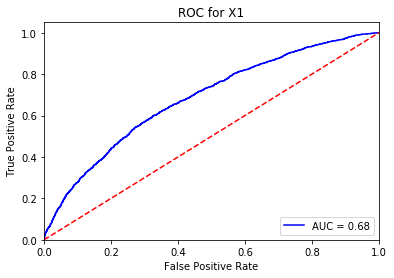

In [273]:
ROC_plotter( (fpr1, tpr1, score1), name = "X1") 

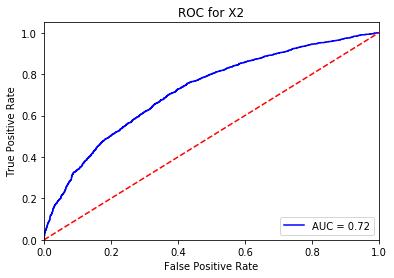

In [274]:
ROC_plotter( (fpr2, tpr2, score2), name = "X2") 

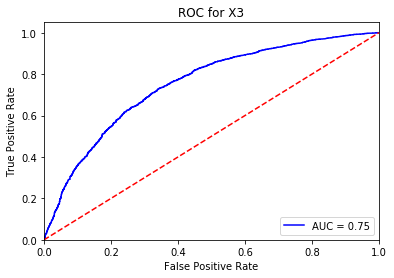

In [275]:
ROC_plotter( (fpr3, tpr3, score3), name = "X3") 

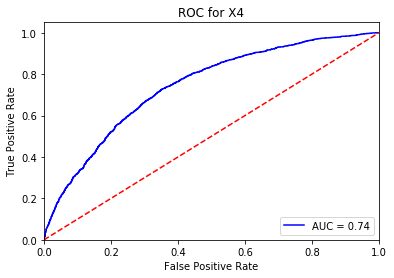

In [276]:
ROC_plotter( (fpr4, tpr4, score4), name = "X4") 

Rebuilding the simple Bag of Words model from Part 1 of the tutorial as a baseline for comparison:

In [80]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 

In [85]:
def review_to_words( raw_review ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review, "html.parser").get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))   
    


num_reviews = train["review"].size

clean_train_reviews3 = []
clean_test_reviews3 = []

for i in range( 0, num_reviews ):
    # Call our function for each one, and add the result to the list of
    # clean reviews
    clean_train_reviews3.append( review_to_words( train["review"][i] ) )
    clean_test_reviews3.append( review_to_words( test["review"][i] ) )

In [86]:

X_counts = vectorizer.fit_transform(clean_train_reviews3)

X_counts = X_counts.toarray()

vocab = vectorizer.get_feature_names()

dist = np.sum(X_counts, axis=0)

X_counts2 = vectorizer.fit_transform(clean_test_reviews3)

X_counts2 = X_counts2.toarray()


In [91]:
X5_tr, X5_ts, y_tr, y_ts = train_test_split(X_counts, y, test_size=0.2, random_state=0)

In [92]:
param_grid = {"max_depth": [None, 2, 5, 10],
              "n_estimators": range(80,100,10) ,
              "min_samples_leaf": range(50,100,10)
             }

In [93]:
rf_clf5 = GridSearchCV(rf, param_grid=  param_grid, verbose = 5, scoring = 'roc_auc' ,cv = 5 , n_jobs = -1 )
rf_clf5.fit(X5_tr , y_tr )

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] min_samples_leaf=50, max_depth=None, n_estimators=80 ............
[CV] min_samples_leaf=50, max_depth=None, n_estimators=80 ............
[CV] min_samples_leaf=50, max_depth=None, n_estimators=80 ............
[CV] min_samples_leaf=50, max_depth=None, n_estimators=80 ............
[CV] min_samples_leaf=50, max_depth=None, n_estimators=80 ............
[CV] min_samples_leaf=50, max_depth=None, n_estimators=90 ............
[CV] min_samples_leaf=50, max_depth=None, n_estimators=90 ............
[CV] min_samples_leaf=50, max_depth=None, n_estimators=90 ............
[CV]  min_samples_leaf=50, max_depth=None, n_estimators=80, score=0.900632, total= 1.0min
[CV] min_samples_leaf=50, max_depth=None, n_estimators=90 ............
[CV]  min_samples_leaf=50, max_depth=None, n_estimators=80, score=0.911038, total= 1.1min


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.1min


[CV]  min_samples_leaf=50, max_depth=None, n_estimators=80, score=0.911857, total= 1.0min
[CV] min_samples_leaf=50, max_depth=None, n_estimators=90 ............
[CV]  min_samples_leaf=50, max_depth=None, n_estimators=80, score=0.906579, total= 1.1min
[CV] min_samples_leaf=60, max_depth=None, n_estimators=80 ............
[CV]  min_samples_leaf=50, max_depth=None, n_estimators=80, score=0.896330, total= 1.1min
[CV] min_samples_leaf=60, max_depth=None, n_estimators=80 ............
[CV] min_samples_leaf=60, max_depth=None, n_estimators=80 ............
[CV]  min_samples_leaf=50, max_depth=None, n_estimators=90, score=0.910737, total= 1.2min
[CV]  min_samples_leaf=50, max_depth=None, n_estimators=90, score=0.900333, total= 1.1min
[CV] min_samples_leaf=60, max_depth=None, n_estimators=80 ............
[CV]  min_samples_leaf=50, max_depth=None, n_estimators=90, score=0.912037, total= 1.1min
[CV] min_samples_leaf=60, max_depth=None, n_estimators=80 ............
[CV] min_samples_leaf=60, max_dept

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.5min


[CV] min_samples_leaf=60, max_depth=2, n_estimators=80 ...............
[CV]  min_samples_leaf=50, max_depth=2, n_estimators=90, score=0.888650, total=  13.9s
[CV] min_samples_leaf=60, max_depth=2, n_estimators=80 ...............
[CV]  min_samples_leaf=50, max_depth=2, n_estimators=90, score=0.881583, total=  15.6s
[CV] min_samples_leaf=60, max_depth=2, n_estimators=90 ...............
[CV]  min_samples_leaf=50, max_depth=2, n_estimators=90, score=0.872572, total=  15.7s
[CV]  min_samples_leaf=60, max_depth=2, n_estimators=80, score=0.878244, total=  13.6s
[CV] min_samples_leaf=60, max_depth=2, n_estimators=90 ...............
[CV]  min_samples_leaf=90, max_depth=None, n_estimators=90, score=0.894899, total=  47.9s
[CV] min_samples_leaf=60, max_depth=2, n_estimators=90 ...............
[CV]  min_samples_leaf=60, max_depth=2, n_estimators=80, score=0.869451, total=  12.6s
[CV] min_samples_leaf=60, max_depth=2, n_estimators=90 ...............
[CV]  min_samples_leaf=60, max_depth=2, n_estimat

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 10.0min


[CV]  min_samples_leaf=90, max_depth=5, n_estimators=90, score=0.884920, total=  21.6s
[CV] min_samples_leaf=50, max_depth=10, n_estimators=80 ..............
[CV]  min_samples_leaf=90, max_depth=5, n_estimators=90, score=0.887111, total=  21.8s
[CV] min_samples_leaf=50, max_depth=10, n_estimators=90 ..............
[CV]  min_samples_leaf=90, max_depth=5, n_estimators=90, score=0.891011, total=  21.4s
[CV] min_samples_leaf=50, max_depth=10, n_estimators=90 ..............
[CV]  min_samples_leaf=90, max_depth=5, n_estimators=90, score=0.886272, total=  21.5s
[CV] min_samples_leaf=50, max_depth=10, n_estimators=90 ..............
[CV]  min_samples_leaf=50, max_depth=10, n_estimators=80, score=0.903256, total=  32.2s
[CV] min_samples_leaf=50, max_depth=10, n_estimators=90 ..............
[CV]  min_samples_leaf=50, max_depth=10, n_estimators=80, score=0.896181, total=  32.5s
[CV] min_samples_leaf=50, max_depth=10, n_estimators=90 ..............
[CV]  min_samples_leaf=50, max_depth=10, n_estimat

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 13.8min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'min_samples_leaf': range(50, 100, 10), 'max_depth': [None, 2, 5, 10], 'n_estimators': range(80, 100, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=5)

In [94]:
rf_clf5.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=70,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=90, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [95]:

M5 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=70,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=90, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [96]:
M5.fit(X5_tr , y_tr)
y_pred5 = M5.predict_proba(X5_ts)[:,1]



In [97]:

fpr5, tpr5, _ = roc_curve(y_ts ,y_pred5 )

score5 = auc(fpr5, tpr5)

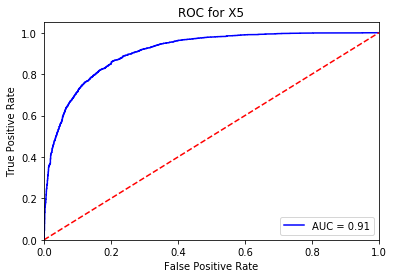

In [99]:
ROC_plotter( (fpr5, tpr5, score5), name = "X5") 

### Kaggle submissions

Predicting y values based on the Kaggle test sets..

In [285]:
start = time.time()
y_score1 = rf_clf1.fit(X1, y).predict(X1_test)



# Get the end time and print how long the process took
end = time.time()
elapsed = end - start
print ("Time taken for X1 predictions: ", elapsed, "seconds.")

Time taken for X1 predictions:  716.4940731525421 seconds.


In [283]:
start =  time.time()
y_score2 = rf_clf2.fit(X2, y).predict(X2_test)


# Get the end time and print how long the process took
end = time.time()
elapsed = end - start
print ("Time taken for X2 predictions: ", elapsed, "seconds.")

Time taken for X2 predictions:  667.0361881256104 seconds.


In [281]:
start =  time.time()
y_score3 = rf_clf3.fit(X3, y).predict(X3_test)


# Get the end time and print how long the process took
end = time.time()
elapsed = end - start
print ("Time taken for X3 predictions: ", elapsed, "seconds.")

Time taken for X3 predictions:  1659.5089130401611 seconds.


In [282]:
start = time.time()
y_score4 = rf_clf4.fit(X4, y).predict(X4_test)


# Get the end time and print how long the process took
end = time.time()
elapsed = end - start
print ("Time taken for X4 predictions: ", elapsed, "seconds.")

Time taken for X4 predictions:  1646.3665499687195 seconds.


In [121]:
start =  time.time()
y_score5 = rf_clf5.fit(X_counts, np.array(train["sentiment"].tolist())).predict(X_counts2)


# Get the end time and print how long the process took
end = time.time()
elapsed = end - start
print ("Time taken for X5 predictions: ", elapsed, "seconds.")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] min_samples_leaf=50, max_depth=None, n_estimators=80 ............
[CV] min_samples_leaf=50, max_depth=None, n_estimators=80 ............
[CV] min_samples_leaf=50, max_depth=None, n_estimators=80 ............
[CV] min_samples_leaf=50, max_depth=None, n_estimators=80 ............
[CV] min_samples_leaf=50, max_depth=None, n_estimators=80 ............
[CV] min_samples_leaf=50, max_depth=None, n_estimators=90 ............
[CV] min_samples_leaf=50, max_depth=None, n_estimators=90 ............
[CV] min_samples_leaf=50, max_depth=None, n_estimators=90 ............
[CV]  min_samples_leaf=50, max_depth=None, n_estimators=80, score=0.905636, total= 1.4min
[CV]  min_samples_leaf=50, max_depth=None, n_estimators=80, score=0.911825, total= 1.4min
[CV] min_samples_leaf=50, max_depth=None, n_estimators=90 ............


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.5min


[CV] min_samples_leaf=50, max_depth=None, n_estimators=90 ............
[CV]  min_samples_leaf=50, max_depth=None, n_estimators=80, score=0.901735, total= 1.5min
[CV] min_samples_leaf=60, max_depth=None, n_estimators=80 ............
[CV]  min_samples_leaf=50, max_depth=None, n_estimators=80, score=0.913012, total= 1.5min
[CV]  min_samples_leaf=50, max_depth=None, n_estimators=80, score=0.906887, total= 1.5min
[CV] min_samples_leaf=60, max_depth=None, n_estimators=80 ............
[CV] min_samples_leaf=60, max_depth=None, n_estimators=80 ............
[CV]  min_samples_leaf=50, max_depth=None, n_estimators=90, score=0.906962, total= 1.6min
[CV] min_samples_leaf=60, max_depth=None, n_estimators=80 ............
[CV]  min_samples_leaf=50, max_depth=None, n_estimators=90, score=0.912808, total= 1.6min
[CV] min_samples_leaf=60, max_depth=None, n_estimators=80 ............
[CV]  min_samples_leaf=50, max_depth=None, n_estimators=90, score=0.902542, total= 1.5min
[CV] min_samples_leaf=60, max_dept

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  8.5min


[CV] min_samples_leaf=60, max_depth=2, n_estimators=80 ...............
[CV]  min_samples_leaf=50, max_depth=2, n_estimators=90, score=0.877004, total=  14.3s
[CV] min_samples_leaf=60, max_depth=2, n_estimators=80 ...............
[CV]  min_samples_leaf=50, max_depth=2, n_estimators=90, score=0.871858, total=  14.6s
[CV] min_samples_leaf=60, max_depth=2, n_estimators=90 ...............
[CV]  min_samples_leaf=90, max_depth=None, n_estimators=90, score=0.911434, total= 1.0min
[CV]  min_samples_leaf=60, max_depth=2, n_estimators=80, score=0.868473, total=  12.8s
[CV] min_samples_leaf=60, max_depth=2, n_estimators=90 ...............
[CV]  min_samples_leaf=60, max_depth=2, n_estimators=80, score=0.887330, total=  12.4s
[CV] min_samples_leaf=60, max_depth=2, n_estimators=90 ...............
[CV]  min_samples_leaf=60, max_depth=2, n_estimators=80, score=0.867376, total=  11.9s
[CV] min_samples_leaf=60, max_depth=2, n_estimators=90 ...............
[CV]  min_samples_leaf=90, max_depth=None, n_esti

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 12.9min


[CV] min_samples_leaf=50, max_depth=10, n_estimators=80 ..............
[CV]  min_samples_leaf=90, max_depth=5, n_estimators=90, score=0.898265, total=  27.4s
[CV] min_samples_leaf=50, max_depth=10, n_estimators=80 ..............
[CV]  min_samples_leaf=90, max_depth=5, n_estimators=90, score=0.883362, total=  28.9s
[CV] min_samples_leaf=50, max_depth=10, n_estimators=90 ..............
[CV]  min_samples_leaf=90, max_depth=5, n_estimators=90, score=0.900658, total=  28.4s
[CV] min_samples_leaf=50, max_depth=10, n_estimators=90 ..............
[CV]  min_samples_leaf=90, max_depth=5, n_estimators=90, score=0.896738, total=  27.4s
[CV] min_samples_leaf=50, max_depth=10, n_estimators=90 ..............
[CV]  min_samples_leaf=50, max_depth=10, n_estimators=80, score=0.903339, total=  39.9s
[CV] min_samples_leaf=50, max_depth=10, n_estimators=90 ..............
[CV]  min_samples_leaf=50, max_depth=10, n_estimators=80, score=0.907231, total=  39.5s
[CV] min_samples_leaf=50, max_depth=10, n_estimato

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 17.6min finished


Time taken for X5 predictions:  1112.1471800804138 seconds.


In [286]:
df = pd.DataFrame(data = {"id": test["id"], "sentiment": y_score1})
df.to_csv("sampleSubmission1.csv", quoting = 3, index = False)
df = pd.DataFrame(data = {"id": test["id"], "sentiment": y_score2})
df.to_csv("sampleSubmission2.csv", quoting = 3, index = False)
df = pd.DataFrame(data = {"id": test["id"], "sentiment": y_score3})
df.to_csv("sampleSubmission3.csv", quoting = 3, index = False)
df = pd.DataFrame(data = {"id": test["id"], "sentiment": y_score4})
df.to_csv("sampleSubmission4.csv", quoting = 3, index = False)
#df = pd.DataFrame(data = {"id": test["id"], "sentiment": y_score5})
#df.to_csv("sampleSubmission.csv", quoting = 3, index = False)

### Kaggle submission scores

X1

<a href="http://imgur.com/rIrLvGN"><img src="http://i.imgur.com/rIrLvGN.png" title="source: imgur.com" /></a>

X2

<a href="http://imgur.com/RvLearN"><img src="http://i.imgur.com/RvLearN.png" title="source: imgur.com" /></a>


X3

<a href="http://imgur.com/bCNxM0G"><img src="http://i.imgur.com/bCNxM0G.png" title="source: imgur.com" /></a>


X4

<a href="http://imgur.com/8tDQtKQ"><img src="http://i.imgur.com/8tDQtKQ.png" title="source: imgur.com" /></a>


X5

<a href="http://imgur.com/CQlxzpr"><img src="http://i.imgur.com/CQlxzpr.png?1" title="source: imgur.com" /></a>

## Part c

Based on the Kaggle submission scores, we can see that the fourth featurization technique (using an LDA model with 20 topics) worked best for sentiment classification. It had an in-sample ROC AUC score of 0.74 and a Kaggle score of 0.68236. 

This is better than the Kaggle score achieved by using a simple bag of words (0.60), however the simple BOW model had a higher insample AUC score. 

To improve the classifier, we can take the following 3 steps:

1) Use a higher number of topics (i.e. greater than 20)

2) Train the model on a larger corpus (i.e. including the unlabeled training data)

3) Tune the random forest classifier's parameters over a larger grid of values to arrive at an optimum classifier.